In [1]:
import os
from collections import Counter, defaultdict
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import pyBigWig
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Added GT tag for SVs

In [2]:
ncells = [50, 75, 100, 125, 150, 200, 250, 300, 350]

for ncell in ncells:
    path1 = "../../A1_NanoStrandseqAssembly/results/HG001_Cell_%d/sv/quantify_lite.tsv" % ncell
    path2 = "results/quant_phased_svs.HG001_Cell_%d.tsv" % ncell
    
    dat = pd.read_csv(path1, sep="\t")
    
    if False: # loose
        min_cell = 1
        min_read = 2
        foldchange = 2
    else: # stringent
        min_cell = 2
        min_read = 4
        foldchange = 3

    for hp in ["HP1", "HP2"]:
        values = dat[["AgreeRead_%s" % hp, "AgreeCell_%s" % hp, "DisagreeRead_%s" % hp, "DisagreeCell_%s" % hp]].values
        ts = []
        for agree_read, agree_cell, disagree_read, disagree_cell in values:
            t = "Uncertain" # Exist, NotExist
            if agree_cell >= min_cell and agree_cell >= disagree_cell * foldchange \
                and agree_read >= min_read and agree_read >= disagree_read * foldchange:
                t = "Exist"
            if disagree_cell >= min_cell and disagree_cell >= agree_cell * foldchange \
                and disagree_read >= min_read and disagree_read >= agree_read * foldchange:
                assert t != "Exist"
                t = "NotExist"
            ts.append(t)
        dat["Existence_%s" % hp] = ts
        
    gts = []
    for v1, v2 in dat[["Existence_HP1", "Existence_HP2"]].values:
        gt = "."
        if v1 == "Exist":
            if v2 == "Exist":
                gt = "1|1"
            elif v2 == "NotExist":
                gt = "1|0"
        elif v1 == "NotExist":
            if v2 == "Exist":
                gt = "0|1"
        gts.append(gt)
    dat["GenoType"] = gts
    
    dat.to_csv(path2, sep="\t", index=False)

# Number of phased SVs

In [3]:
ncell = 350
dat = pd.read_csv("results/quant_phased_svs.HG001_Cell_%d.tsv" % ncell, sep="\t")
dat = dat[dat["GenoType"] != "."]
d1 = dat[["DEL" in x for x in dat["Name_HP1"]]]
d2 = dat[["INS" in x for x in dat["Name_HP1"]]]
len(d1), len(d2)

(5184, 4667)

[1862 3322 1979 2688]


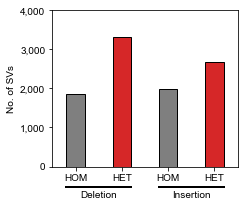

In [4]:
c1 = len(d1[d1["GenoType"] == "1|1"])
c2 = len(d1) - c1
c3 = len(d2[d2["GenoType"] == "1|1"])
c4 = len(d2) - c3

xs = np.arange(4)
ys = np.array([c1, c2, c3, c4])
print(ys)
ylim = 4000
w = 0.4

plt.figure(figsize=(3.5, 3))
plt.bar(xs, ys, width=w, edgecolor="black", color=["C7", "C3", "C7", "C3"])
plt.text(0.5, ylim * -0.2, "Deletion", ha="center")
plt.text(2.5, ylim * -0.2, "Insertion", ha="center")
plt.plot([0 - w / 2, 1 + w / 2], [ylim * -0.13, ylim * -0.13], lw=2, color="black", clip_on=False)
plt.plot([2 - w / 2, 3 + w / 2], [ylim * -0.13, ylim * -0.13], lw=2, color="black", clip_on=False)

plt.xlim(-0.5, 3.5)
plt.xticks(xs, ["HOM", "HET", "HOM", "HET"])
plt.ylim(0, ylim)
vs = np.arange(0, ylim + 1, 1000)
plt.yticks(vs, [format(v, ",") for v in vs])
plt.ylabel("No. of SVs")
plt.tight_layout()
plt.savefig("figures/number_of_phased_svs.350cells.pdf", dpi=300)

# Number of phased SVs (downsample)

In [5]:
ncells = [50, 75, 100, 125, 150, 200, 250, 300, 350]
dats = []

for ncell in ncells:
    dat = pd.read_csv("results/quant_phased_svs.HG001_Cell_%d.tsv" % ncell, sep="\t")
    dats.append(dat)

In [6]:
counters = []
for ncell, dat in zip(ncells, dats):
    counter = defaultdict(int)
    for name, gt in dat[["Name_HP1", "GenoType"]].values:
        if gt == ".":
            continue
        svtype = name.split(".")[1]
        if gt == "1|1":
            s = "HOM"
        else:
            s = "HET"
        counter[(svtype, s)] += 1
    counters.append(counter)
for ncell, counter in zip(ncells, counters):
    print(ncell, sorted(counter.items()), sep="\t")

50	[(('DEL', 'HET'), 188), (('DEL', 'HOM'), 68), (('INS', 'HET'), 66), (('INS', 'HOM'), 46)]
75	[(('DEL', 'HET'), 678), (('DEL', 'HOM'), 319), (('INS', 'HET'), 299), (('INS', 'HOM'), 187)]
100	[(('DEL', 'HET'), 1272), (('DEL', 'HOM'), 623), (('INS', 'HET'), 601), (('INS', 'HOM'), 425)]
125	[(('DEL', 'HET'), 1846), (('DEL', 'HOM'), 907), (('INS', 'HET'), 999), (('INS', 'HOM'), 683)]
150	[(('DEL', 'HET'), 2249), (('DEL', 'HOM'), 1162), (('INS', 'HET'), 1341), (('INS', 'HOM'), 899)]
200	[(('DEL', 'HET'), 2740), (('DEL', 'HOM'), 1476), (('INS', 'HET'), 1863), (('INS', 'HOM'), 1308)]
250	[(('DEL', 'HET'), 3066), (('DEL', 'HOM'), 1694), (('INS', 'HET'), 2317), (('INS', 'HOM'), 1623)]
300	[(('DEL', 'HET'), 3220), (('DEL', 'HOM'), 1792), (('INS', 'HET'), 2543), (('INS', 'HOM'), 1823)]
350	[(('DEL', 'HET'), 3322), (('DEL', 'HOM'), 1862), (('INS', 'HET'), 2688), (('INS', 'HOM'), 1979)]


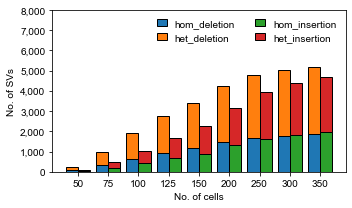

In [7]:
xs = np.arange(len(ncells))
xs1 = xs - w / 2
xs2 = xs + w / 2
ys1 = [counter[("DEL", "HOM")] for counter in counters]
ys2 = [counter[("DEL", "HET")] for counter in counters]
ys3 = [counter[("INS", "HOM")] for counter in counters]
ys4 = [counter[("INS", "HET")] for counter in counters]

w = 0.4

plt.figure(figsize=(5, 3))
plt.bar(xs1, ys1, width=w, edgecolor="black", label="hom_deletion")
plt.bar(xs1, ys2, bottom=ys1, width=w, edgecolor="black", label="het_deletion")
plt.bar(xs2, ys3, width=w, edgecolor="black", label="hom_insertion")
plt.bar(xs2, ys4, bottom=ys3, width=w, edgecolor="black", label="het_insertion")
plt.xticks(xs, map(str, ncells))
plt.xlabel("No. of cells")
plt.ylabel("No. of SVs")
ys = np.arange(0, 8000 + 1, 1000)
plt.yticks(ys, [format(y, ",") for y in ys])
plt.legend(ncol=2, handlelength=1, frameon=False)
plt.tight_layout()
plt.savefig("figures/number_of_phased_svs.pdf", dpi=300)

# Repeat element of SVs

In [14]:
ncell = 350

f_vcf = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_%d/sv/cutesv.filtered.vcf.gz" % ncell
f_tsv = "results/quant_phased_svs.HG001_Cell_%d.tsv" % ncell

with pysam.VariantFile(f_vcf) as f:
    records = {r.id: r for r in f}

dat = pd.read_csv(f_tsv, sep="\t")
dat = dat[(dat["GenoType"] != ".") & (dat["Length_HP1"] >= 100)]
print("SV numebr (>= 100 bp):", len(dat))

SV numebr (>= 100 bp): 5828


In [ ]:
with open("data/deletion_insertion_sequences.fasta", "w+") as fw:
    for name in dat["Name_HP1"]:
        record = records[name]
        svtype = record.info["SVTYPE"]
        ref, alt = record.ref, record.alts[0]
        chrom = record.contig
        start = record.start
        end = record.stop
        if svtype == "INS":
            seq = alt[1:]
        elif svtype == "DEL":
            seq = ref[1:]
        else:
            continue
        fw.write(">%s %s:%d-%d\n" % (name, chrom, start, end))
        fw.write("%s\n" % seq)

In [95]:
fasta = "data/deletion_insertion_sequences.fasta"
outdir = "data/deletion_insertion_sequences_rmsk"
log = "data/deletion_insertion_sequences_rmsk.log"
cmd = "RepeatMasker -pa 24 -species human -poly -html -gff -dir %s %s > %s" % (outdir, fasta, log)
print(cmd)
assert os.system(cmd) == 0

RepeatMasker -pa 24 -species human -poly -html -gff -dir data/deletion_insertion_sequences_rmsk data/deletion_insertion_sequences.fasta > data/deletion_insertion_sequences_rmsk.log


In [15]:
out = "data/deletion_insertion_sequences_rmsk/deletion_insertion_sequences.fasta.out"
data = defaultdict(list)
with open(out) as f:
    for line in f.readlines()[3:]:
        row = line.split()
        if row[8] == "+":
            begin, end, left = int(row[11]), int(row[12]), int(row[13][1:-1])
        elif row[8] == "C":
            left, end, begin = int(row[11][1:-1]), int(row[12]), int(row[13])
        element_length = end + left
        ratio = (end - begin) / element_length
        #if ratio < 0.9:
            #continue
        #if left > 10 or begin > 10:
        #    continue
        name = row[10]
        if name == "Unknown":
            continue
        if name.startswith("LINE") or name.startswith("SINE") or name.startswith("LTR") or name.startswith("Satellite"): #  or name.startswith("DNA"):
            data[row[4]].append(row[10])

In [16]:
len(data), len(dat)

(3628, 5828)

In [9]:
def counting(elements):
    line = 0
    sine = 0
    ltr = 0
    tandem_repeat = 0
    for e in elements:
        if e.startswith("LINE"):
            line += 1
        if e.startswith("SINE"):
            sine += 1
        if e.startswith("LTR"):
            ltr += 1
        if e.startswith("Satellite"):
            tandem_repeat += 1
    return line, ltr, sine, tandem_repeat


with_element = 0
counts = np.zeros(5) # 
counter = defaultdict(int) #

for name, elements in data.items():
    if len(elements) == 0:
        continue
    
    line, ltr, sine, tandem_repeat = counting(elements)
    if line + ltr + sine + tandem_repeat > 0:
        with_element += 1
    
    ss = []
    if line > 0:
        ss.append("%d LINE" % line)
    if ltr > 0:
        ss.append("%d LTR" % ltr)
    if sine > 0:
        ss.append("%d SINE" % sine)
    if tandem_repeat > 0:
        ss.append("%d Tandem repeat" % tandem_repeat)
    s = " + ".join(ss)
    
    if len(elements) > 1:
        counter[s] += 1
        
    if len(elements) == 1:
        if line == 1:
            counts[0] += 1
        elif ltr == 1:
            counts[1] += 1
        elif sine == 1:
            counts[2] += 1
        elif tandem_repeat == 1:
            counts[3] += 1
        else:
            pass
            # counts[5] += 1
    else:
        counts[4] += 1

In [10]:
print(counts)
ratios = counts * 100 / sum(counts)
print(ratios)

[ 359.  163. 2530.   62.  514.]
[ 9.8952591   4.49283352 69.7353914   1.70893054 14.16758545]


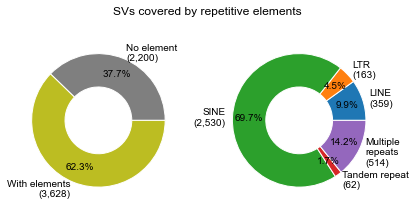

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6 ,3))

plt.suptitle("SVs covered by repetitive elements")

plt.sca(axs[0])
no_element = len(dat) - with_element
labels = ["No element\n(%s)" % format(no_element, ","), "With elements\n(%s)" % format(with_element, ",")]
plt.pie([no_element, with_element], 
        colors=["C7", "C8"], 
        pctdistance=0.75,
        autopct="%.1f%%",
        wedgeprops=dict(width=0.5, edgecolor='w'), 
        labels=labels)

plt.sca(axs[1])
labels = ["LINE", "LTR", "SINE", "Tandem repeat", "Multiple\nrepeats"]
for i in range(len(labels)):
    labels[i] = "%s\n(%s)" % (labels[i], format(int(counts[i]), ","))
wedges, texts, autotexts = plt.pie(
    counts, 
    autopct="%.1f%%", 
    pctdistance=0.75, 
    colors=["C0", "C1", "C2", "C3", "C4"],
    wedgeprops=dict(width=0.5, edgecolor='w'),
    labels=labels)

plt.tight_layout()
plt.savefig("figures/repeat_element_cover_sv.pdf", dpi=300)

# Distance from nearest hetSNP to hetSV

In [13]:
def load_het_snps(f_vcf):
    snps = []
    with pysam.VariantFile(f_vcf) as f:
        sample = list(f.header.samples)[0]
        for record in f:
            gt = record.samples[sample]["GT"]
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]          
            if len(a1) > 1 or len(a2) > 1 or a1 == a2:
                continue
            if len(record.ref) > 1:
                continue
            name = "%s/%s" % (a1, a2)
            snp = GRange(chrom=record.contig, start=record.start, end=record.stop, name=name)
            snps.append(snp)
    snps.sort()
    return snps


def get_closest_snp(sv, loader, width=20000):
    closest_distance = None
    closest_snp = None
    
    for snp in loader.fetch(chrom=sv.chrom, start=sv.start - width, end = sv.end + width):
        if snp.end < sv.start:
            distance = sv.start - snp.end
        elif snp.start > sv.end:
            distance = snp.start - sv.end
        else:
            continue
            
        if distance < 10:
            continue
            
        if closest_snp is None:
            closest_distance = distance
            closest_snp = snp
        elif distance <= closest_distance:
            closest_distance = distance
            closest_snp = snp
        else:
            break
        
    return closest_distance, closest_snp

def get_closest_snp(sv, loader, width=20000):
    array = []
    for snp in loader.fetch(chrom=sv.chrom, start=sv.start - width, end = sv.end + width):
        if snp.end < sv.start:
            distance = sv.start - snp.end
        elif snp.start > sv.end:
            distance = snp.start - sv.end
        else:
            distance = 0
        array.append([distance, snp])
    array = list(filter(lambda item: item[0] >= 10, array))
    array.sort()
    if len(array) > 0:
        return array[0][0], array[0][1]
    else:
        return None, None

def get_distances(svs, snps):
    distances = []
    width = 20000
    loader = ShiftLoader(snps)
    for sv in svs:
        closest_distance, closest_snp = get_closest_snp(sv, loader, width)
        if closest_distance is None:
            closest_distance = width
        distances.append(closest_distance)
    return distances

In [9]:
# load SVs

data_svs = dict()

# HG001

svs = []
dat = pd.read_csv("results/quant_phased_svs.HG001_Cell_350.tsv", sep="\t")
dat = dat[(dat["GenoType"] == "0|1") | (dat["GenoType"] == "1|0")]
for chrom, start, end, name in dat[["Chrom_HP1", "Start_HP1", "End_HP1", "Name_HP1"]].values:
    sv = GRange(chrom=chrom, start=start, end=end, name=name)
    svs.append(sv)
svs.sort()
print(len(svs))
data_svs["HG001_hetSVs"] = svs

# HG002

svs = []
with pysam.VariantFile("../../GRCh38_HG002_NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz") as f:
    sample = list(f.header.samples)[0]
    for record in f:
        if list(record.filter)[0] != "PASS":
            continue
        gt = record.samples[sample]["GT"]
        if gt[0] == gt[1]:
            continue
        chrom = "chr%s" % record.contig
        sv = GRange(chrom=chrom, start=record.start, end=record.stop, name=record.id)
        sv.record = record
        svs.append(sv)
svs.sort()
print(len(svs))
data_svs["HG002_hetSVs"] = svs

6010
6938


In [10]:
# load SNPs

data_snps = dict()
data_snps["HG001_NSS_hetSNPs"] = load_het_snps("../../A1_NanoStrandseqAssembly/results/HG001_Cell_350/round2/snvs.vcf.gz")
data_snps["HG001_GIAB_hetSNPs"] = load_het_snps("../../GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.vcf.gz")
data_snps["HG001_Pacbio_hetSNPs"] = load_het_snps("../../6_nss-pseudobulk-analysis/results/snvs/concated/nanocaller/PacBio.full.vcf.gz")
data_snps["HG002_GIAB_hetSNPs"] = load_het_snps("../../GIAB/HG002/HG002_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.corrected.vcf.gz")

HG001_hetSVs	HG001_NSS_hetSNPs
HG001_hetSVs	HG001_GIAB_hetSNPs
HG001_hetSVs	HG001_Pacbio_hetSNPs
HG002_hetSVs	HG002_GIAB_hetSNPs


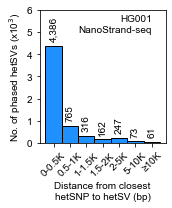

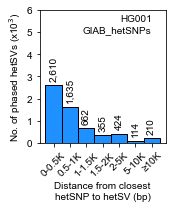

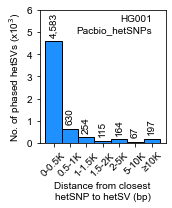

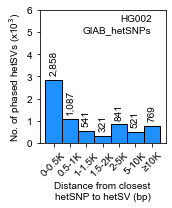

In [14]:
pairs = [
    ["HG001_hetSVs", "HG001_NSS_hetSNPs"],
    ["HG001_hetSVs", "HG001_GIAB_hetSNPs"],
    ["HG001_hetSVs", "HG001_Pacbio_hetSNPs"],
    ["HG002_hetSVs", "HG002_GIAB_hetSNPs"]
]

for k1, k2 in pairs:
    print(k1, k2, sep="\t")
    svs = data_svs[k1]
    snps = data_snps[k2]
    distances = get_distances(svs, snps)
    counts = [
        len(list(filter(lambda v: 0 <= v < 500, distances))),
        len(list(filter(lambda v: 500 <= v < 1000, distances))),
        len(list(filter(lambda v: 1000 <= v < 1500, distances))),
        len(list(filter(lambda v: 1500 <= v < 2000, distances))),
        len(list(filter(lambda v: 2000 <= v < 5000, distances))),
        len(list(filter(lambda v: 5000 <= v < 10000, distances))),
        len(list(filter(lambda v: 10000 <= v, distances))),
    ]
    xs = np.arange(len(counts))
    xticks = ["0-0.5K", "0.5-1K", "1-1.5K", "1.5-2K", "2-5K", "5-10K", "≥10K"]
    plt.figure(figsize=(2.5, 3))
    plt.bar(xs, counts, color="dodgerblue", edgecolor="black", width=1)
    for x, y in zip(xs, counts):
        if x >= 0:
            plt.text(x, y + 200, format(y, ","), ha="center", va="bottom", rotation=90)
    if True:
        plt.text(len(counts) - 1, 5500, k1.split("_")[0], ha="right")
        s = k2.split("_")[1]
        if s == "NSS":
            s = "NanoStrand-seq"
        else:
            s = "%s_hetSNPs" % s
        plt.text(len(counts) - 1, 5000, s, ha="right")
    plt.xlabel("Distance from closest\nhetSNP to hetSV (bp)")
    plt.xticks(xs, xticks, rotation=45, ha="center")
    plt.ylabel("No. of phased hetSVs (x10$^3$)")
    ys = np.arange(0, 6000 + 1, 1000)
    plt.yticks(ys, [int(y/1000) for y in ys])
    plt.tight_layout()
    plt.savefig("figures/distance_from_snp_to_sv.%s_and_%s.pdf" % (k1, k2), dpi=300)
    # break

In [23]:
pairs = [
    ["HG001_hetSVs", "HG001_NSS_hetSNPs"],
    ["HG001_hetSVs", "HG001_GIAB_hetSNPs"],
    ["HG001_hetSVs", "HG001_Pacbio_hetSNPs"],
    ["HG002_hetSVs", "HG002_GIAB_hetSNPs"]
]

svs = data_svs["HG001_hetSVs"]
snps = data_snps["HG001_NSS_hetSNPs"]
distances = get_distances(svs, snps)
mapper = {sv.name: distance for sv, distance in zip(svs, distances)}
dat["Nearest_hetSNP_Distance"] = [mapper[name] for name in dat["Name_HP1"]]

In [26]:
dat.to_csv("results/HG001_hetSVs_HG001_NSS_hetSNPs.distances.tsv", sep="\t", index=False)

# Characteristic of SVs

In [4]:
dat = pd.read_csv("results/HG001_hetSVs_HG001_NSS_hetSNPs.distances.tsv", sep="\t")
svs = []
for chrom, start, end, name, gt, distance in dat[["Chrom_HP1", "Start_HP1", "End_HP1", "Name_HP1", "GenoType", "Nearest_hetSNP_Distance"]].values:
    sv = GRange(chrom=chrom, start=start, end=end, name=name, strand="+")
    sv.genotype = gt
    sv.score = distance
    sv.het_snp_distance = distance
    svs.append(sv)
svs.sort()

with open("results/HG001_phased_hetSVs.bed", "w+") as fw:
    for sv in svs:
        fw.write(sv.format() + "\n")

In [17]:
labels = ["0 - 500", "500 - 5,000", "≥ 5,000"]
colors = ["C7", "C0", "C3"]

svs_list_raw = [
        list(filter(lambda sv: 0 <= sv.het_snp_distance < 500, svs)),
        list(filter(lambda sv: 500 <= sv.het_snp_distance < 5000, svs)),
        list(filter(lambda sv: 5000 <= sv.het_snp_distance, svs)),
    ]
svs_list = svs_list_raw
[len(x) for x in svs_list]

[4386, 1490, 134]

In [18]:
if True: # downsample SVs
    import random
    tmp = []
    random.seed(0)
    for x in svs_list:
        tmp.append(random.sample(x, 134))
    svs_list = tmp
[len(x) for x in svs_list]

[134, 134, 134]

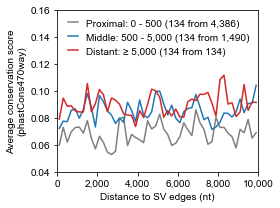

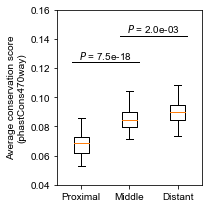

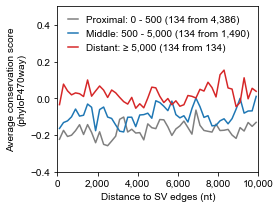

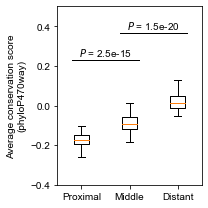

In [19]:
params = [
    ["phastCons470way", "/home/chenzonggui/species/homo_sapiens/ucsc/hg38.phastCons470way.bw", [0.04, 0.16]],
    ["phyloP470way", "/home/chenzonggui/species/homo_sapiens/ucsc/hg38.phyloP470way.bw", [-0.4, 0.5]]
]
groups = ["Proximal", "Middle", "Distant"]

for name, f_bw, (ylim1, ylim2) in params:
    data = []
    width = 10000
    step = 200
    
    bw = pyBigWig.open(f_bw)
    for svs1 in svs_list:
        rows = []
        for sv in svs1:
            vs1 = np.nan_to_num(bw.values(sv.chrom, sv.start - width - 200, sv.start - 200), 0)[::-1]
            vs2 = np.nan_to_num(bw.values(sv.chrom, sv.end + 200, sv.end + width + 200), 0)
            rows.append(np.mean(vs1.reshape((-1, step)), axis=1))
            rows.append(np.mean(vs2.reshape((-1, step)), axis=1))
        data.append(np.array(rows))
    bw.close()
    
    plt.figure(figsize=(4, 3))
    for i, m in enumerate(data):
        xs = np.arange(len(m[0])) * step + step / 2
        ys = np.mean(m, axis=0)
        yerr = np.std(m, axis=0)
        plt.plot(xs, ys, color=colors[i], 
                 label="%s: %s (%s from %s)" % (groups[i], 
                                                labels[i], 
                                                format(int(len(m)/2), ","), 
                                                format(len(svs_list_raw[i]), ",")))
    xs = np.arange(0, 10000 + 1, 2000)
    ticks = [format(x, ",") for x in xs]
    plt.xticks(xs, ticks)
    plt.xlim(0, width)
    plt.xlabel("Distance to SV edges (nt)")
    plt.ylim(ylim1, ylim2)
    plt.ylabel("Average conservation score\n(%s)" % name)
    plt.legend(handlelength=1, frameon=False)
    plt.tight_layout()
    plt.savefig("figures/conservation_score.lines.%s.pdf" % name, dpi=300)
    
    plt.figure(figsize=(3, 3))
    array = [np.mean(m, axis=0) for m in data]
    plt.boxplot(array, showfliers=False) # axis的值影响很大
    plt.ylim(ylim1, ylim2)
    h = ylim2 - ylim1
    y1 = ylim1 + h * 0.7
    y2 = ylim1 + h * 0.85
    plt.plot([1 - 0.2, 2 + 0.2], [y1, y1], lw=1, color="black")
    plt.plot([2 - 0.2, 3 + 0.2], [y2, y2], lw=1, color="black")
    plt.text(1.5, y1 + h * 0.02, "$\it{P}$ = %.1e" % ttest_ind(array[0], array[1])[1], ha="center")
    plt.text(2.5, y2 + h * 0.02, "$\it{P}$ = %.1e" % ttest_ind(array[1], array[2])[1], ha="center")
    plt.ylabel("Average conservation score\n(%s)" % name)
    plt.xticks([1, 2, 3], ["Proximal", "Middle", "Distant"])
    plt.tight_layout()
    plt.savefig("figures/conservation_score.violin.%s.pdf" % name, dpi=300)

    #break

In [23]:
svs = svs_list_raw[-1].copy()
svs.sort()
print(len(svs))

134


In [29]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = [x for x in f]
print(len(transcripts))

244939


In [30]:
transcripts = list(sorted(filter(lambda t: t.thick is not None, transcripts)))
print(len(transcripts))

107497


In [56]:
loader = ShiftLoader(transcripts)
array = []
for sv in svs:
    if sv.het_snp_distance < 10000:
        continue
    sv.gene_loc = None
    distance = np.inf
    for t in loader.fetch(chrom=sv.chrom, start=sv.start - 100000, end=sv.end + 100000):
        if t.end < sv.start:
            dis = sv.start - t.end
        elif t.start > sv.end:
            dis = t.start - sv.end
        else:
            dis = 0
            loc = "intron"
            for block in t.blocks:
                if max(block[0], sv.start) < min(block[1], sv.end):
                    loc = "exon"
            sv.gene_loc = loc
        if distance is None:
            distance = dis
        else:
            distance = min(distance, dis)
    if distance == 0:
        # print(sv.format())
        print(sv.gene_loc, "%s:%d-%d" % (sv.chrom, sv.start, sv.end), sep="\t")
    array.append(distance)

exon	chr1:59296667-59296718
intron	chr1:97316516-97316517
intron	chr1:186327185-186327186
intron	chr10:119313031-119313032
intron	chr10:133291292-133292484
intron	chr11:576799-576875
intron	chr12:49436512-49436593
intron	chr14:49652156-49652314
intron	chr15:50340879-50340950
intron	chr15:66039838-66039939
intron	chr16:57860067-57860068
intron	chr17:7037068-7037443
intron	chr17:47557415-47557918
intron	chr18:75012294-75012398
intron	chr20:49325676-49325677
intron	chr3:51588356-51588357
intron	chr3:177225153-177225154
intron	chr4:81753714-81754311
intron	chr6:125962231-125962284
intron	chr6:163013382-163013535
intron	chr7:746388-746389
intron	chr9:133391177-133391229
exon	chrX:47233763-47233816
intron	chrX:53578701-53578925
intron	chrX:136023187-136023240
exon	chrX:155057022-155057451


In [55]:
array = np.array(array)
array = np.sort(array)
a = sum(array == 0)
c = sum(array > 100000)
b = len(array) - a - c
print(a, b, c)

26 16 19
